<a href="https://colab.research.google.com/github/delpretemarcus/156StockClosingPricePrediction/blob/main/ClosePriceOnly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Stock Market Prediction And Forecasting Using Stacked LSTM

In [2]:
import pandas as pd
import numpy as np

In [3]:

aplurl = 'https://raw.githubusercontent.com/delpretemarcus/156StockClosingPricePrediction/main/HistoricalQuotes.csv'

df = pd.read_csv(aplurl, index_col='Date')

In [4]:
#Data Cleaning --

df.columns = ['Close', 'Volume', 'Open', 'High', 'Low']
df.index = pd.to_datetime(df.index)
df.sort_index()

df.Close = df.Close.apply(lambda x: x[2:]).astype(np.double)
df.Open = df.Open.apply(lambda x: x[2:]).astype(np.double)
df.High = df.High.apply(lambda x: x[2:]).astype(np.double)
df.Low = df.Low.apply(lambda x: x[2:]).astype(np.double)

df = df.reindex(index=df.index[::-1])


In [5]:
df

,Close,Volume,Open,High,Low
Date,,,,,
2010-03-01,29.8557,137312041,29.3928,29.9286,29.3500
2010-03-02,29.8357,141486282,29.9900,30.1186,29.6771
2010-03-03,29.9043,92846488,29.8486,29.9814,29.7057
2010-03-04,30.1014,89591907,29.8971,30.1314,29.8043
2010-03-05,31.2786,224647427,30.7057,31.3857,30.6614
...,...,...,...,...,...
2020-02-24,298.1800,55548830,297.2600,304.1800,289.2300
2020-02-25,288.0800,57668360,300.9500,302.5300,286.1300
2020-02-26,292.6500,49678430,286.5300,297.8800,286.5000


In [6]:
df1=df.reset_index()['Close']

In [7]:
df1

0        29.8557
1        29.8357
2        29.9043
3        30.1014
4        31.2786
          ...   
2513    298.1800
2514    288.0800
2515    292.6500
2516    273.5200
2517    273.3600
Name: Close, Length: 2518, dtype: float64

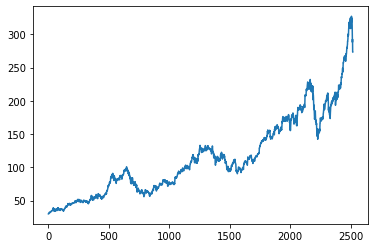

In [8]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [9]:
df1

0        29.8557
1        29.8357
2        29.9043
3        30.1014
4        31.2786
          ...   
2513    298.1800
2514    288.0800
2515    292.6500
2516    273.5200
2517    273.3600
Name: Close, Length: 2518, dtype: float64

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [11]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.80)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [12]:
training_size,test_size

(2014, 504)

In [13]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]    
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [14]:
# reshape into X=t,t+1,t+2,t+3... t+99 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [15]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [16]:
### Create the Stacked LSTM model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [35]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


In [36]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_7 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_8 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [37]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
30/30 [==============================] - 15s 250ms/step - loss: 0.0105 - val_loss: 0.0072
Epoch 2/100
30/30 [==============================] - 6s 198ms/step - loss: 3.9539e-04 - val_loss: 0.0020
Epoch 3/100
30/30 [==============================] - 6s 198ms/step - loss: 2.2490e-04 - val_loss: 0.0019
Epoch 4/100
30/30 [==============================] - 6s 199ms/step - loss: 2.1919e-04 - val_loss: 0.0021
Epoch 5/100
30/30 [==============================] - 6s 200ms/step - loss: 2.0904e-04 - val_loss: 0.0022
Epoch 6/100
30/30 [==============================] - 6s 197ms/step - loss: 2.0596e-04 - val_loss: 0.0021
Epoch 7/100
30/30 [==============================] - 6s 198ms/step - loss: 2.0142e-04 - val_loss: 0.0020
Epoch 8/100
30/30 [==============================] - 6s 196ms/step - loss: 1.9601e-04 - val_loss: 0.0023
Epoch 9/100
30/30 [==============================] - 6s 202ms/step - loss: 2.0325e-04 - val_loss: 0.0025
Epoch 10/100
30/30 [==============================] - 6s 2

In [38]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [39]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [40]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

99.76887338294267

In [41]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

217.17822546974162

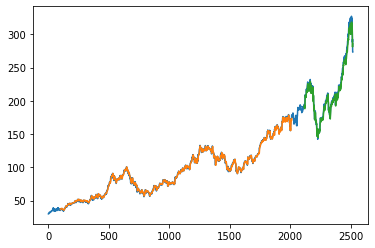

In [42]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

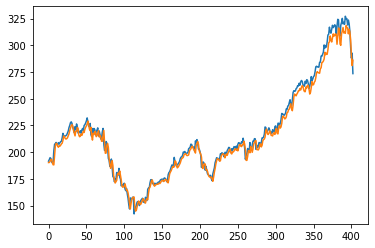

In [43]:
plt.plot(scaler.inverse_transform(df1)[len(train_predict)+(look_back*2)+1:len(df1)-1, :])
plt.plot(test_predict)
plt.show()

In [44]:
#Consider Adding some stuff of actual dates for xaxis instead of "days since"

In [45]:
#Need to flesh out regardless